# Comparison of Similarity: Semsimian vs. Large Language Model Embeddings

## Case 1: HP vs HP

### Setup

In [3]:
!pip install oaklib==0.5.18rc2 polars seaborn seaborn_polars matplotlib
!pip install git+https://github.com/monarch-initiative/ontogpt.git
# Depending on the environment you may also need python3-dev


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
  Cloning https://github.com/monarch-initiative/ontogpt.git to /tmp/pip-req-build-887ospo0
  Running command git clone --filter=blob:none --quiet https://github.com/monarch-initiative/ontogpt.git /tmp/pip-req-build-887ospo0
  Resolved https://github.com/monarch-initiative/ontogpt.git to commit 4849f4ce7c54f0394c263fdcad832f7a9eabd52b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [1]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn_polars as snl

from ontogpt.clients import OpenAIClient

In [2]:
# This could be generalized to any target
termfile = 'hp_terms.tsv'
simfile = 'hp_vs_hp_semsim.tsv'

### Semsim for HP through Semsimian and OAK

In [14]:
# Retrieve the ontology, get the class list, and process into batches
!runoak -i sqlite:obo:hp descendants -p i HP:0000118 > {termfile}
!split -l 500 --numeric-suffixes {termfile} terms

In [ ]:
# This is just a test set: the descendants of "Abnormality of the voice" - it's only 24 objects
!runoak -vvv -i semsimian:sqlite:obo:hp similarity --no-autolabel -p i .desc//p=i HP:0001608 @ .desc//p=i HP:0001608 -O csv -o {simfile}

The following will do all PA vs all PA for HP. That's pretty large (>17k objects) which is why we use batches.

Plus this is running without a threshold - we really do want to compare everything we can.

This outputs to a single file so we append.

In [16]:
! for batch in terms*; do runoak -vvv -i semsimian:sqlite:obo:hp similarity --no-autolabel -p i --set1-file $batch --set2-file "hp_terms.tsv" -O csv >> 'hp_vs_hp_semsim.tsv'; done

INFO:root:Setting other_languages=()
INFO:root:Settings = Settings(impl=None, autosave=False, associations_type=None, preferred_language=None, other_languages=())
INFO:root:Wrapping an existing OAK implementation to fetch sqlite:obo:hp
INFO:root:Locator: obo:hp
INFO:root:Ensuring gunzipped for https://s3.amazonaws.com/bbop-sqlite/hp.db.gz
INFO:root:Locator, post-processed: sqlite:////home/harry/.data/oaklib/hp.db
DEBUG:root:Paths to search: [PurePosixPath('model/schema'), PurePosixPath('schema'), PurePosixPath('linkml'), PurePosixPath('src/linkml'), PurePosixPath('src/model'), PurePosixPath('src/model/schema'), PurePosixPath('src/schema'), PurePosixPath('.')]
DEBUG:root:candidate model/schema not found
DEBUG:root:candidate schema not found
DEBUG:root:candidate linkml not found
DEBUG:root:candidate src/linkml not found
DEBUG:root:candidate src/model not found
DEBUG:root:candidate src/model/schema not found
DEBUG:root:candidate src/schema not found
INFO:root:out=None <class 'NoneType'>
I

In [25]:
# Output is already concatenated since we appended, but it will have extra headings we need to remove
# But then add the heading again because we still want it
!sed -i '/^subject/d' {simfile}
!sed -i '1s/^/subject_id\tsubject_label\tsubject_source\tobject_id\tobject_label\tobject_source\tancestor_id\tancestor_label\tancestor_source\tobject_information_content\tsubject_information_content\tancestor_information_content\tjaccard_similarity\tcosine_similarity\tdice_similarity\tphenodigm_score\n/' {simfile}

In [15]:
!head {simfile}

subject_id	subject_label	subject_source	object_id	object_label	object_source	ancestor_id	ancestor_label	ancestor_source	object_information_content	subject_information_content	ancestor_information_content	jaccard_similarity	cosine_similarity	dice_similarity	phenodigm_score
HP:0006276	None	None	HP:0001471	None	None	HP:0000118	None	None	None	None	0.8020531768157838	0.14285714285714285	None	None	0.33849523668642323
HP:0006276	None	None	HP:0005329	None	None	HP:0000118	None	None	None	None	0.8020531768157838	0.13333333333333333	None	None	0.32701746677423493
HP:0006276	None	None	HP:0011482	None	None	HP:0000118	None	None	None	None	0.8020531768157838	0.11764705882352941	None	None	0.307179421954735
HP:0006276	None	None	HP:0033562	None	None	HP:0000118	None	None	None	None	0.8020531768157838	0.14285714285714285	None	None	0.33849523668642323
HP:0006276	None	None	HP:0000974	None	None	HP:0000118	None	None	None	None	0.8020531768157838	0.13333333333333333	None	None	0.32701746677423493
HP:0006276	None	Non

In [48]:
# The full semsim table is large, so we: 
# use low_memory=True
# and pre-assign dtypes
# and use .filter to specify which columns to load
# and use the lazy loader (scan_csv), because we're only going to use one metric at a time anyway

dtypes = {"subject_id": pl.Categorical,
          "subject_label": pl.Categorical,
          "subject_source": pl.Categorical,
          "object_id": pl.Categorical,
          "object_label": pl.Categorical,
          "object_source": pl.Categorical,
          "ancestor_id": pl.Categorical,
          "ancestor_label": pl.Categorical,
          "ancestor_source": pl.Categorical,
          "object_information_content": pl.Categorical,
          "subject_information_content": pl.Categorical,
          "ancestor_information_content": pl.Float32,
          "jaccard_similarity": pl.Float32,
          "cosine_similarity": pl.Categorical,
          "dice_similarity": pl.Categorical,
          "phenodigm_score": pl.Float32
          }
simsdf = pl.scan_csv(simfile, has_header=True, separator='\t', low_memory=True, dtypes=dtypes, null_values="None", infer_schema_length=0)

# Use the next lines to load all non-null values into their own DF directly
# wantcols = ["subject_id", "object_id", "ancestor_id", "ancestor_information_content", "jaccard_similarity", "phenodigm_score"]
# simsdf = pl.scan_csv(simfile, has_header=True, separator='\t', low_memory=True, dtypes=dtypes, null_values="None", infer_schema_length=0).select(wantcols).collect()

In [4]:
# Setup
metrics = ["jaccard_similarity", "ancestor_information_content", "phenodigm_score"]

In [7]:
# A quick score summary. 
# this should show that <1% of the pairs have a jaccard above 0.5
# i.e., most aren't that similar
realdf = simsdf.select(metrics[0]).collect()
realdf[metrics[0]].hist(bin_count=2)

break_point,category,jaccard_similarity_count
f64,cat,u32
-1.0,"""(-inf, -1.0]""",0
0.5,"""(-1.0, 0.5]""",290619636
inf,"""(0.5, inf]""",1687773


(0.0, 1.0, 0.0, 1.0)

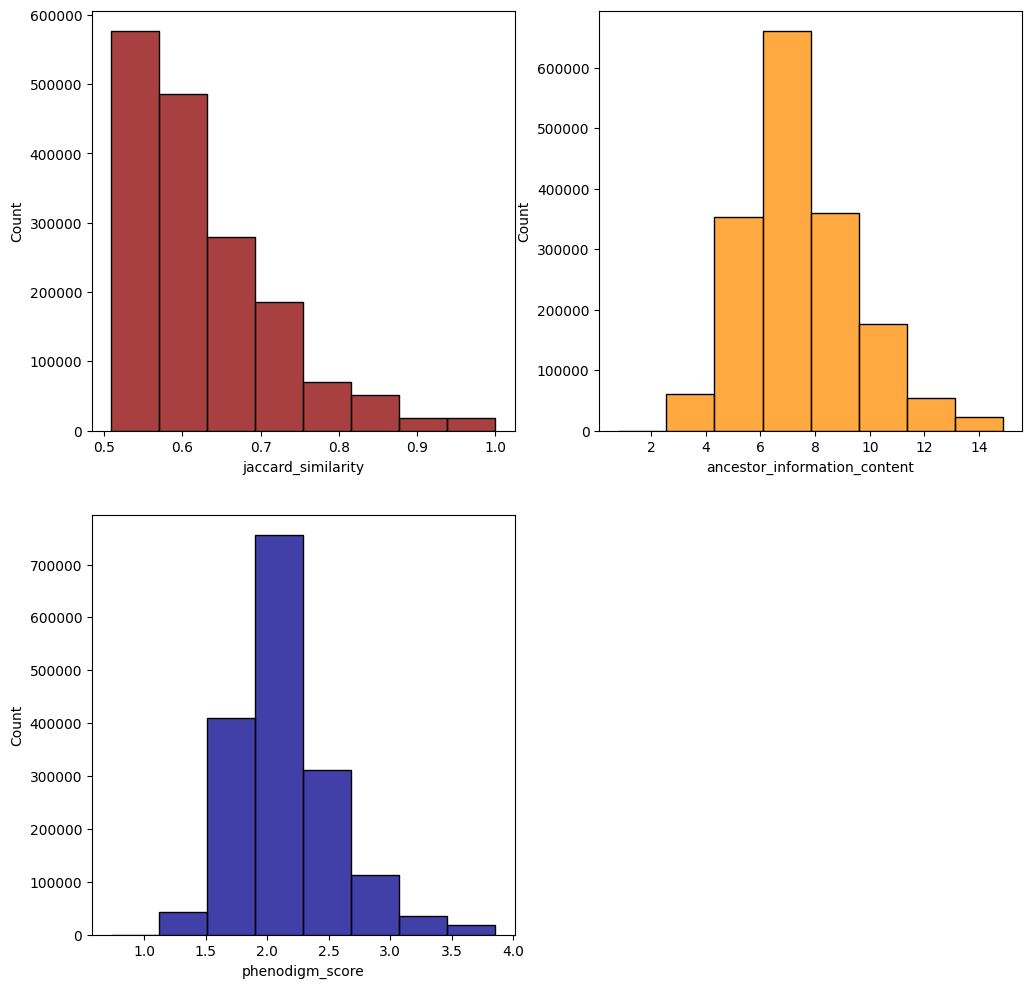

In [8]:
# Histograms
# These don't load everything but use a filter of jaccard >0.5,
# as in practice we don't really care about the very distant pairs
histdf = simsdf.select(metrics).filter(pl.col(metrics[0]) > 0.5).collect()
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
snl.histplot(histdf, x=metrics[0], bins=8, color="darkred", ax=axs[0, 0])
snl.histplot(histdf, x=metrics[1], bins=8, color="darkorange", ax=axs[0, 1])
snl.histplot(histdf, x=metrics[2], bins=8, color="darkblue", ax=axs[1, 0])
axs[1, 1].axis('off')

### Embeddings for HP through OntoGPT and GPT-3.5

The basic idea here is to get all term labels, get embedding for each, and get cosine sim for each pair.
OntoGPT has the `entity-similarity` command already to do the latter two of these.

In [4]:
embed_cosimfile = 'hp_vs_hp_embed_cosim.tsv'

In [5]:
# Get all the term CURIEs
id_cols = ["subject_id", "object_id", "ancestor_id"]
id_df = simsdf.select(id_cols).collect()
all_term_ids = set(pl.concat([id_df["subject_id"], id_df["object_id"], id_df["ancestor_id"]]))
all_term_ids

{'HP:0006500',
 'HP:0030762',
 'HP:0032884',
 'HP:0100899',
 'HP:0032216',
 'HP:0034543',
 'HP:0031593',
 'HP:0004404',
 'HP:0034988',
 'HP:0025321',
 'HP:0008457',
 'HP:0004991',
 'HP:0034692',
 'HP:0008373',
 'HP:0000556',
 'HP:0005478',
 'HP:0004007',
 'HP:0033909',
 'HP:0002716',
 'HP:0040051',
 'HP:0002679',
 'HP:0033321',
 'HP:0100317',
 'HP:0100098',
 'HP:0032009',
 'HP:0032950',
 'HP:0000316',
 'HP:0001937',
 'HP:0032728',
 'HP:0006554',
 'HP:0012872',
 'HP:0006961',
 'HP:0003537',
 'HP:5200030',
 'HP:0011476',
 'HP:0034314',
 'HP:0000647',
 'HP:0010665',
 'HP:0031129',
 'HP:0005984',
 'HP:0041212',
 'HP:0045058',
 'HP:0034130',
 'HP:0005147',
 'HP:0100283',
 'HP:0012068',
 'HP:0009716',
 'HP:0100175',
 'HP:0005900',
 'HP:0025727',
 'HP:0031442',
 'HP:0011367',
 'HP:0000008',
 'HP:0004736',
 'HP:0008736',
 'HP:0100260',
 'HP:0012522',
 'HP:0006642',
 'HP:0007178',
 'HP:0003327',
 'HP:0008830',
 'HP:0003538',
 'HP:0000331',
 'HP:0500001',
 'HP:0002304',
 'HP:0000256',
 'HP:00085

In [14]:
# Quick sanity check
len(all_term_ids)

17098

In [24]:
# Prep that term list
batch_size = 500
all_term_ids_list = list(all_term_ids)
all_term_batches = [" ".join(all_term_ids_list[i:i + batch_size]) for i in range(0, len(all_term_ids_list), batch_size)]
len(all_term_batches)

35

In [25]:
# Get cosine sim
# Note that the OntoGPT entity-similarity command takes a list of CURIEs but will do all vs all comparisons
# This is another instance in which we need to do batch processing, as this command also expects command line input
# and we may exceed the maximum number of string arguments (raising OSError: [Errno 7] Argument list too long).
# We also append results to a single file.

# For now, this just does a single batch.
# One batch of 500 terms appears to take about an hour

!ontogpt -vvv entity-similarity -r sqlite:obo:hp {all_term_batches[0]} -o {embed_cosimfile} -O yaml --no-definitions --no-parents --no-logical-definitions --no-autolabel --no-synonyms

In [26]:
!head {embed_cosimfile}

subject_id	subject_label	object_id	object_label	embedding_cosine_similarity	object_rank_for_subject
HP:0033439	None	HP:0033439	None	1.0000000000000002	0
HP:0033439	None	HP:0033446	None	0.9697898042332884	1
HP:0033439	None	HP:0033326	None	0.9147667427351647	2
HP:0033439	None	HP:0033437	None	0.9141252077336193	3
HP:0033439	None	HP:0034365	None	0.9136764418178103	4
HP:0033439	None	HP:0034936	None	0.9131785821983672	5
HP:0033439	None	HP:0034934	None	0.9098953528955156	6
HP:0033439	None	HP:0034870	None	0.9069151027031489	7
HP:0033439	None	HP:0003077	None	0.897538148309068	8


In [49]:
# As above, lazy load the data

dtypes = {"subject_id": pl.Categorical,
          "subject_label": pl.Categorical,
          "object_id": pl.Categorical,
          "object_label": pl.Categorical,
          "embedding_cosine_similarity": pl.Float32,
          "object_rank_for_subject": pl.Int8
          }
embed_cosimsdf = pl.scan_csv(embed_cosimfile, has_header=True, separator='\t', low_memory=True, dtypes=dtypes, null_values="None", infer_schema_length=0)

### Combined plot

Note that both the semsim file and the embed-cosine file need to cover the same ID space, or there won't be anything to compare.

In [51]:
# Get a combined ID string for each table first.
# Do a join of embed data and semsim data
wantsimsdfcols = ["pair_id", "ancestor_information_content", "jaccard_similarity", "phenodigm_score"]
wantembedsdfcols = ["pair_id", "embedding_cosine_similarity"]

simsdf = simsdf.with_columns((pl.col("subject_id") + "+" + pl.col("object_id")).alias("pair_id")).select(wantsimsdfcols)
embed_cosimsdf = embed_cosimsdf.with_columns((pl.col("subject_id") + "+" + pl.col("object_id")).alias("pair_id")).select(wantembedsdfcols)

In [63]:
# Sanity check
simsdf.fetch(n_rows=100)

pair_id,ancestor_information_content,jaccard_similarity,phenodigm_score
str,f32,f32,f32
"""HP:0006276+HP:…",0.802053,0.142857,0.338495
"""HP:0006276+HP:…",0.802053,0.133333,0.327017
"""HP:0006276+HP:…",0.802053,0.117647,0.307179
"""HP:0006276+HP:…",0.802053,0.142857,0.338495
"""HP:0006276+HP:…",0.802053,0.133333,0.327017
"""HP:0006276+HP:…",0.802053,0.133333,0.327017
"""HP:0006276+HP:…",0.802053,0.111111,0.298525
"""HP:0006276+HP:…",0.802053,0.117647,0.307179
"""HP:0006276+HP:…",0.802053,0.105263,0.290563


In [64]:
# Sanity check
embed_cosimsdf.fetch(n_rows=100)

pair_id,embedding_cosine_similarity
str,f32
"""HP:0033439+HP:…",1.0
"""HP:0033439+HP:…",0.96979
"""HP:0033439+HP:…",0.914767
"""HP:0033439+HP:…",0.914125
"""HP:0033439+HP:…",0.913676
"""HP:0033439+HP:…",0.913179
"""HP:0033439+HP:…",0.909895
"""HP:0033439+HP:…",0.906915
"""HP:0033439+HP:…",0.897538


In [65]:
joined_df = embed_cosimsdf.join(simsdf, on="pair_id")
joined_df.collect()

: 

: 

(0.0, 1.0, 0.0, 1.0)

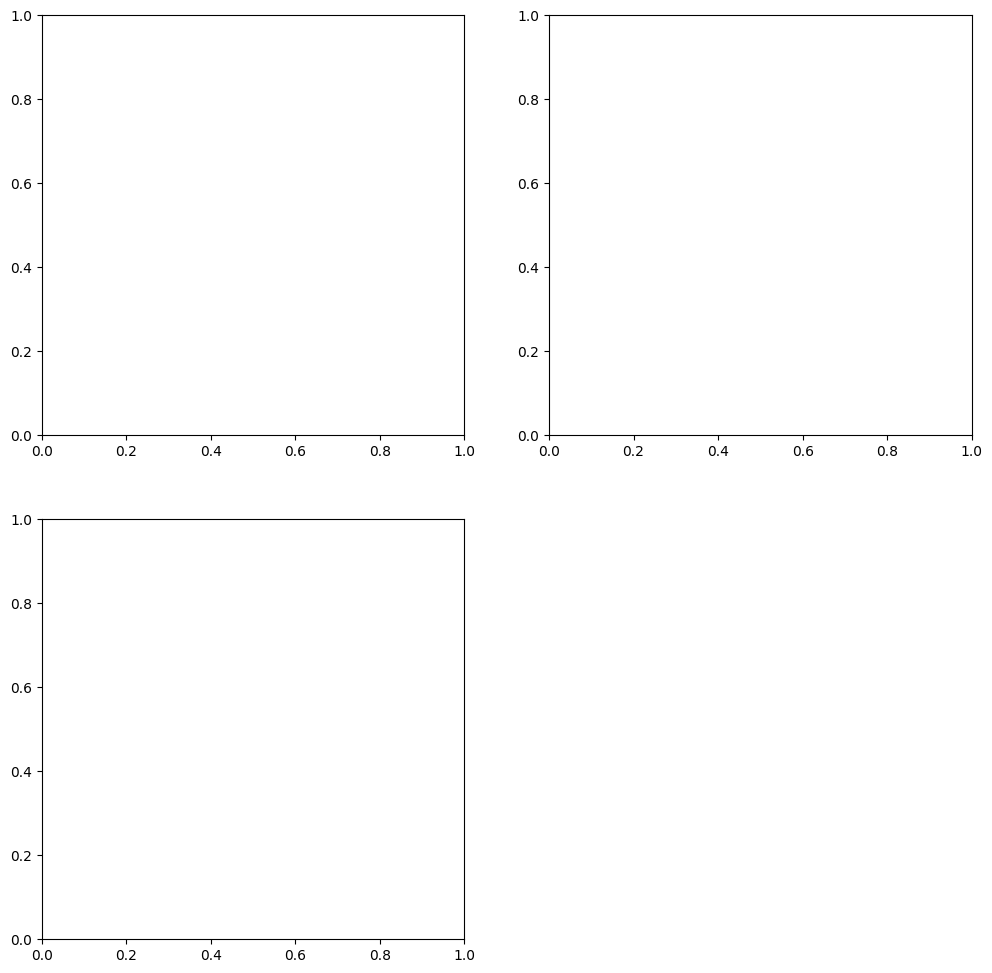

In [7]:
# Scatterplots
plotdf = embed_cosimsdf.collect(streaming=True)
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
snl.scatterplot(plotdf, x='jaccard_similarity', y='embedding_cosine_similarity', color="darkred", ax=axs[0, 0])
snl.scatterplot(plotdf, x='ancestor_information_content', y='embedding_cosine_similarity', color="darkorange", ax=axs[0, 1])
snl.scatterplot(plotdf, x='phenodigm_score', y='embedding_cosine_similarity', color="darkblue", ax=axs[1, 0])
axs[1, 1].axis('off')